# Tutorial 3: How simulations define your predictions
The inverse problem has no unique solution as it is ill-posed. In order to solve it we need to constraint the space of possible solutions. While inverse solutions like minimum-norm estimates have an explicit constraint of minimum-energy, the constraints with esinet are implicit and mostly shaped by the simulations.

This tutorial aims the relation between simulation parameters and predictions.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# import mne
# import numpy as np
# from copy import deepcopy
# import matplotlib.pyplot as plt
import sys; sys.path.insert(0, '../')
from esinet import util
from esinet import Simulation
from esinet import Net
from esinet.forward import create_forward_model, get_info
plot_params = dict(surface='white', hemi='both', verbose=0)

## Create Forward model
First we create a template forward model which comes with the esinet package

In [2]:
info = get_info(sfreq=100)
fwd = create_forward_model(info=info)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.0s remaining:    5.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.1s remaining:    1.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


## Simulate
Next, we simulate two types of data: 
1. Data containing small sources with 15-25 mm in diameter.
2. Data containing large sources with 35-45 mm in diameter.

Note, that for publication-ready inverse solutions you should increase the number of training samples to 100,000.

In [12]:
n_samples = 5000
settings = dict(duration_of_trial=0.25)
sim = Simulation(fwd, info, settings=settings).simulate(n_samples=n_samples)

Simulating data based on sparse patches.


100%|██████████| 5000/5000 [01:18<00:00, 63.43it/s]


## Lets visualize the two types of simulations
The two brain plots should now look quite different, as one contains large and extended sources while the other contains tiny point-like sources.

No projector specified for this dataset. Please consider the method self.add_proj.


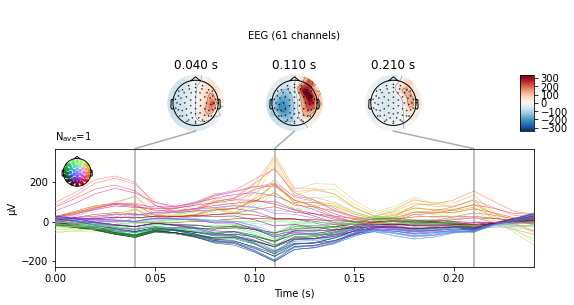

No projector specified for this dataset. Please consider the method self.add_proj.


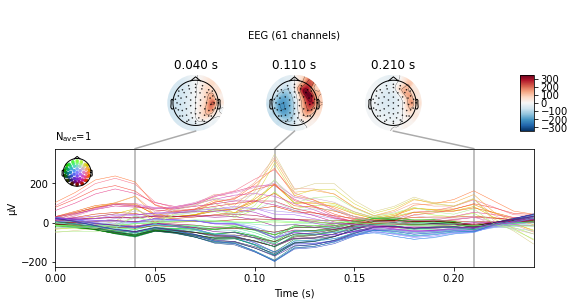

No projector specified for this dataset. Please consider the method self.add_proj.


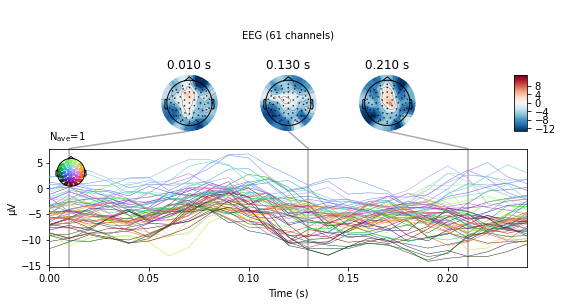

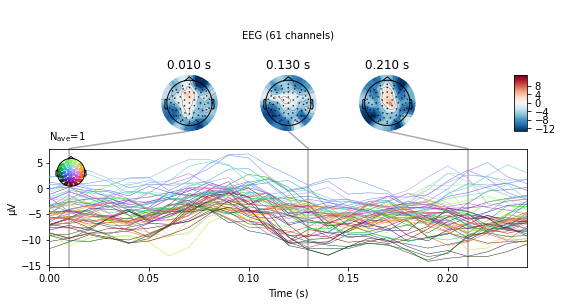

In [13]:
idx = 0
leadfield = fwd["sol"]["data"]
brain = sim.source_data[idx].plot(**plot_params)
brain.add_text(0.1, 0.9, 'Sample', 'title',
               font_size=14)

evoked = sim.eeg_data[idx].average()
evoked.plot_joint()

eeg_noiseless = leadfield @ sim.source_data[idx].data
evoked_nl = evoked.copy()
evoked_nl.data = eeg_noiseless
evoked_nl.plot_joint()

evoked_n = evoked_nl.copy()
evoked_n.data = evoked.data - evoked_nl.data
evoked_n.plot_joint()


## Train individual neural networks

In [14]:
model_type = 'LSTM'  # can be 'LSTM' or 'ConvDip', too
net = Net(fwd, verbose=True, model_type=model_type)
net.fit(sim, epochs=10)

# model_type = 'FC'  # can be 'LSTM' or 'ConvDip', too
# net_fc = Net(fwd, verbose=True, model_type=model_type)
# net_fc.fit(sim, epochs=10)

preprocess data
Model: "Contextualizer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, None, 61)]   0                                            
__________________________________________________________________________________________________
FC1 (TimeDistributed)           (None, None, 200)    12400       Input[0][0]                      
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, None, 200)    0           FC1[0][0]                        
__________________________________________________________________________________________________
LSTM1 (Bidirectional)           (None, None, 64)     44928       dropout_1[0][0]                  
_____________________________________________________________________

KeyboardInterrupt: 

Now we have simulated two different types of source & eeg data and build two neural networks that each was trained on one of these simulations. Lets see how they perform within their own simulation type.

In [18]:
import numpy as np
# Simulate some new, unseen test data    
n_test_samples = 2
# settings["target_snr"] = 50
# settings["extents"] = (1,40)
# settings["number_of_sources"] = 3
# settings["method"] = "noise"
# settings["beta"] = 5

sim_test = Simulation(fwd, info, settings=settings).simulate(n_samples=n_test_samples)
n = sim_test.simulation_info["number_of_sources"].values[0]
print(f"{n} sources")

stc = sim_test.source_data[0]
brain = stc.plot(**plot_params)
brain.add_text(0.1, 0.9, 'Ground Truth of small data', 'title',
               font_size=14)

stc_hat = net.predict(sim_test)[0]
stc_hat.data /= np.max(abs(stc_hat.data))
brain = stc_hat.plot(**plot_params)
brain.add_text(0.1, 0.9, 'LSTM', 'title',
               font_size=14)

# stc_hat = net_fc.predict(sim_test)[0]
# stc_hat.data /= np.max(abs(stc_hat.data))
# brain = stc_hat.plot(**plot_params)
# brain.add_text(0.1, 0.9, 'FC', 'title',
#                font_size=14)

# from esinet.evaluate import eval_auc
# import numpy as np
# pos = util.unpack_fwd(fwd)[3]
# auc = np.mean([eval_auc(y_true, y_est, pos) for y_true, y_est in zip(stc.data.T, stc_hat.data.T)])
# print(f"AUC = {auc:.2f}")

# stc_hat = net_fc.predict(sim_test)[0]
# brain = stc_hat.plot(**plot_params)
# brain.add_text(0.1, 0.9, 'LSTM', 'title',
#                font_size=14)
# from esinet.evaluate import eval_auc
# import numpy as np
# pos = util.unpack_fwd(fwd)[3]
# auc = np.mean([eval_auc(y_true, y_est, pos) for y_true, y_est in zip(stc.data.T, stc_hat.data.T)])
# print(f"AUC = {auc:.2f}")

Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 61.36it/s]


8 sources


c:\Users\lukas\virtualenvs\esienv\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


True eeg shape:  (2, 61, 25)
est eeg shape:  (2, 61, 25)
Residual Variance(s): [4.56, 8.5] [%]


Using control points [0.14209625 0.18342176 0.66248531]
Using control points [0.14040836 0.19640215 0.43587057]


Now we will use the large-net to predict the small simulation and vice versa.

In [ ]:
brain = sim_test_small.source_data[0].plot(**plot_params)
brain.add_text(0.1, 0.9, 'Ground Truth of small data', 'title',
               font_size=14)


brain = net_large.predict(sim_test_small)[0].plot(**plot_params)
brain.add_text(0.1, 0.9, 'Large-Net on small data', 'title',
               font_size=14)



brain = sim_test_large.source_data[0].plot(**plot_params)
brain.add_text(0.1, 0.9, 'Ground Truth of large data', 'title',
               font_size=14)


brain = net_small.predict(sim_test_large)[0].plot(**plot_params)
brain.add_text(0.1, 0.9, 'Small-Net on large data', 'title',
               font_size=14)

We now find that the Net which was trained on large simulations always tends to find large sources - even when confronted with data in which small sources were active. 

Conversely, the Net which was trained on simulations that contain small sources finds sparse sources when confronted with data containing large-source activity.

This demonstrates that our simulation settings function like priors. Further, it emphasizes the importance to state your priors and to motivate your choice.

In many cases we can't make a choice and we want to make as few assumptions into our models as possible. In this case we propose that you use large ranges in your settings to maximize the diversity of your training data.

A sample of a diverse setting is given in the next cell:

In [ ]:
settings = {
    'number_of_sources': (1, 20),  # The range of simultaneously active sources.
    'extents': (1, 50),  # The range of source diameters in mm 
    'amplitudes': (1, 100),  # Defines the range of amplitudes (in arbitrary units)
    'shapes': 'both',  # Simulate both gaussian-shaped and flat sources
    'beta': (0, 3),  # Defines the distribution of the noise in terms of 1/f**beta
}